In [111]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
all_pcoords = []

# skip_iters_until = 30
skip_iters_until = 0

file_path = "west.h5"
with h5py.File(file_path, 'r') as h5_file:
    for iname, ival in h5_file["iterations"].items():
        iteration_index = int(iname.split("_")[-1])
        if iteration_index < skip_iters_until:
            print(iname)
            continue
        iteration_pcoords = ival["pcoord"][:]
        # We only want to include completed segments
        finished_mask = ival["seg_index"]["status"] == 2
        all_pcoords.extend(iteration_pcoords[finished_mask])

all_pcoords = [i.flatten() for i in all_pcoords]

In [117]:
# component_values = [[i[0], i[-1]] for i in all_pcoords]
component_values = [i for i in all_pcoords]

num_bins = 80
component_min = min([min(i) for i in component_values])
component_max = max([max(i) for i in component_values])
component_bins = np.linspace(component_min, component_max, num_bins+1)
# Calculate the binds ourselves because I can't figure out np.digitize tonight - Daniel
# The np.clip call is needed because math here treats the bins as open ranges on the right [a,b), so the max value gets put in next bin
binned_componenents = [np.clip((num_bins*(i-component_min)/(component_max-component_min)).astype(int), None, num_bins-1) for i in component_values]

for i,j in zip(binned_componenents, component_values):
     bad = i[i >= num_bins]
     if len(bad):
          print(bad)
          print(j > component_max)

transition_matrix = np.zeros((num_bins, num_bins), dtype=int)
for i in binned_componenents:
    for j in range(len(i) - 1):
        try:
            #transition_matrix[from_state][to_state]
            transition_matrix[i[j]][i[j+1]] += 1
        except:
            print(j, j+1)
            raise

In [118]:
transition_matrix

array([[1, 2, 2, ..., 0, 0, 0],
       [1, 2, 8, ..., 0, 0, 0],
       [1, 5, 4, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 2, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [119]:
transition_prob_matrix = transition_matrix.astype(np.double)/np.sum(transition_matrix, axis=1, keepdims=True)
transition_prob_matrix = np.nan_to_num(transition_prob_matrix, nan=0.0)

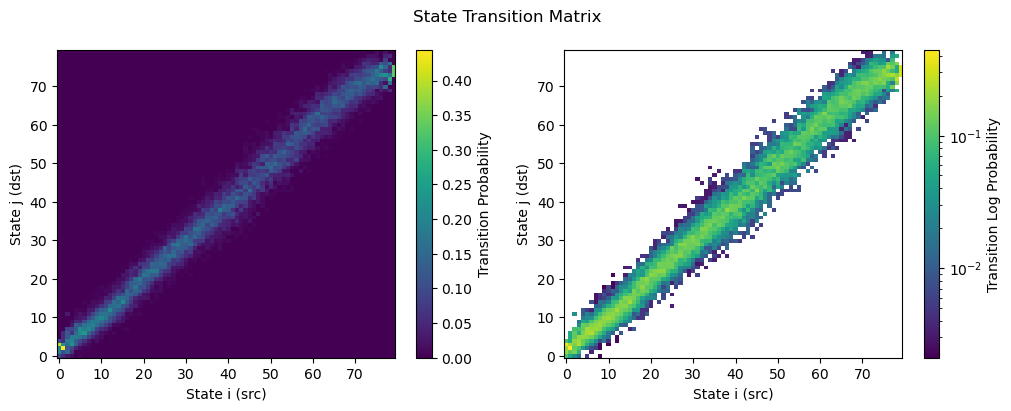

In [120]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
im0 = axes[0].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(im0, label='Transition Probability', ax=axes[0])
axes[0].set_xlabel('State i (src)')
axes[0].set_ylabel('State j (dst)')
# axes[0].set_title('Transition Matrix')

im1 = axes[1].imshow(transition_prob_matrix.T, origin='lower', aspect='auto', cmap='viridis', norm="log")
plt.colorbar(im1, label='Transition Log Probability', ax=axes[1])
axes[1].set_xlabel('State i (src)')
axes[1].set_ylabel('State j (dst)')
axes[1].set_title('')

fig.suptitle("State Transition Matrix")
pass

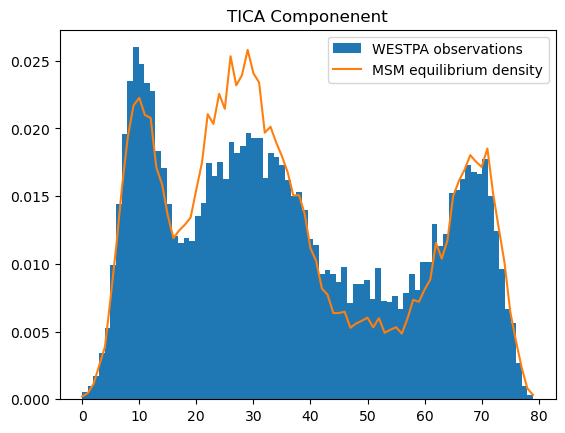

In [121]:
# Linear algebra by ChatGPT
# Solve for the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]

assert stationary_vector.shape[1] == 1, "Stationary distribution is not unique"

# Normalize the stationary vector to sum to 1
stationary_distribution = stationary_vector / np.sum(stationary_vector)
stationary_distribution = stationary_distribution.real.flatten()

plt.title(f"TICA Componenent")
plt.hist(np.concatenate(binned_componenents), bins=num_bins, density=True, label="WESTPA observations")
plt.plot(stationary_distribution, label="MSM equilibrium density")
plt.legend()
pass

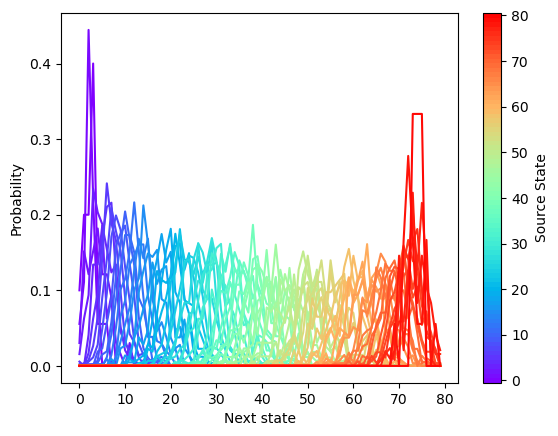

In [122]:
for i in range(len(transition_prob_matrix)):
    plt.plot(transition_prob_matrix[i].T, label=i, c=plt.colormaps["rainbow"](i/len(transition_prob_matrix)))
plt.ylabel("Probability")
plt.xlabel("Next state")
# plt.legend(title="Current State")

plt.colorbar(
    matplotlib.cm.ScalarMappable(cmap=plt.colormaps["rainbow"]),
    ax=plt.gca(), values=[*range(len(transition_prob_matrix)+1)],
    label="Source State")

# plt.colorbar(
#     matplotlib.cm.ScalarMappable(
#         norm = matplotlib.colors.BoundaryNorm([*range(len(transition_prob_matrix)+1)], plt.colormaps["rainbow"].N),
#         cmap=plt.colormaps["rainbow"]),
#     ax=plt.gca(), label="Source State")

pass

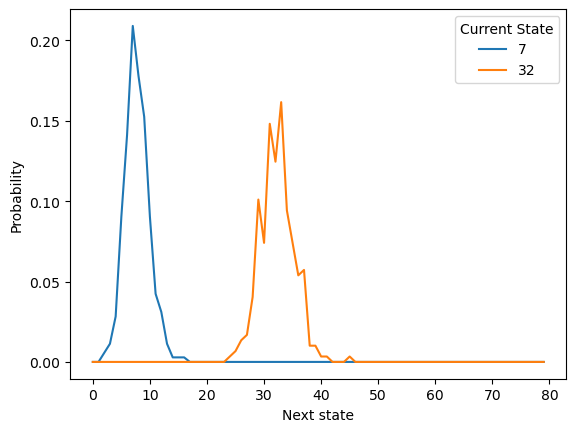

In [123]:
# Examining some individual bins

# for i in range(30,35):
for i in [7, 32]:
    plt.plot(transition_prob_matrix[i].T, label=i)
plt.ylabel("Probability")
plt.xlabel("Next state")
plt.legend(title="Current State")